In [1]:
%load_ext blackcellmagic

In [2]:
import os

os.chdir("..")

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from tqdm.auto import tqdm
import warnings

# Evaluation
from sklearn.metrics import (
    accuracy_score,
    f1_score,
    precision_score,
    recall_score,
    classification_report,
    confusion_matrix,
    make_scorer,
)

# tf-idf
from sklearn.feature_extraction.text import TfidfVectorizer

# Stratified sampling for multi-label classification
from skmultilearn.model_selection import iterative_train_test_split
from skmultilearn.model_selection import IterativeStratification

# Other
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import GridSearchCV

# Classifiers
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB

warnings.filterwarnings("ignore")
np.random.seed(0)

Using TensorFlow backend.


In [4]:
pd.set_option("display.max_rows", 5)
pd.set_option("display.max_columns", None)
pd.set_option("display.max_colwidth", 100)

## 1. Load and transform data

In [5]:
df = pd.read_pickle("data/processed/reports_tokenized.p")
df

,ID,Identifier,Company_Name,ISIN,Ticker,Country_of_Exchange,Financial_Period_Absolute,Financial_Period_Relative,CSR_URL,SDG_1,SDG_2,SDG_3,SDG_4,SDG_5,SDG_6,SDG_7,SDG_8,SDG_9,SDG_10,SDG_11,SDG_12,SDG_13,SDG_14,SDG_15,SDG_16,SDG_17,CSR_Filename,CSR_Text,CSR_Text_clean,CSR_Text_tokenized
0,0,888.L,888 Holdings PLC,GI000A0F6407,888,United Kingdom,2020,FY0,https://corporate.888.com/wp-content/uploads/2021/04/2020-Annual-Report.pdf,False,False,True,True,True,True,True,True,False,NaN,False,True,True,NaN,False,True,False,0_888.L_2020.pdf,888 HOLDINGS PLC\n\nANNUAL REPORT & ACCOUNTS 2020\n\n A YEAR OF \nSTRONG GROWTH \n\n888 IS ONE ...,HOLDINGS PLC ANNUAL REPORT & ACCOUNTS 2020 A YEAR OF STRONG GROWTH 888 IS ONE OF THE WORLDS LEA...,holding plc annual report account year strong growth one world leading online betting gaming com...
1,1,A.N,Agilent Technologies Inc,US00846U1016,A,United States of America,2020,FY0,https://www.agilent.com/about/companyinfo/sustainability/Agilent-Report-CSR-2020.pdf,False,False,True,True,True,True,True,True,False,NaN,False,True,True,NaN,True,True,False,1_A.N_2020.pdf,Delivering on \nour Promises\n\n2020 Corporate Social Responsibility Report\n\n1\n\n Letter fro...,Delivering on our Promises 2020 Corporate Social Responsibility Report 1 Letter from the Presid...,delivering promise corporate social responsibility report letter president stakeholder engagemen...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8154,12676,ZBH.N,Zimmer Biomet Holdings Inc,US98956P1021,ZBH,United States of America,2016,FY-4,https://www.responsibilityreports.com/HostedData/ResponsibilityReportArchive/z/NYSE_ZBH_2016.pdf,False,False,True,True,True,True,True,True,False,NaN,False,True,False,NaN,False,True,False,12676_ZBH.N_2016.pdf,E N V I R O N M E N T A L \n\n \n\nS O C I A L \n\nG O V E R N A N C E\n\nSustainability \nRep...,E N V I R O N M E N T A L S O C I A L G O V E R N A N C E Sustainability Report 2016 T A B L E ...,e n v r n e n l c l g v e r n n c e sustainability report b l e f c n e n company profile corpor...
8155,12677,ZBH.N,Zimmer Biomet Holdings Inc,US98956P1021,ZBH,United States of America,2015,FY-5,https://www.responsibilityreports.com/HostedData/ResponsibilityReportArchive/z/NYSE_ZBH_2015.pdf,False,False,True,True,False,True,True,False,False,NaN,False,True,False,NaN,False,False,False,12677_ZBH.N_2015.pdf,E N V I R O N M E N T A L \n\n \n\nS O C I A L \n\nG O V E R N A N C E\n\nSustainability \nRep...,E N V I R O N M E N T A L S O C I A L G O V E R N A N C E Sustainability Report 2015 Investing ...,e n v r n e n l c l g v e r n n c e sustainability report investing future world b l e f c n e n...


In [6]:
# Data: tf-idf
tfidf = TfidfVectorizer()
X = tfidf.fit_transform(df["CSR_Text_tokenized"])

# Labels: Exclude SDGs 10 and 14
labels = [
    "SDG_1",
    "SDG_2",
    "SDG_3",
    "SDG_4",
    "SDG_5",
    "SDG_6",
    "SDG_7",
    "SDG_8",
    "SDG_9",
    "SDG_11",
    "SDG_12",
    "SDG_13",
    "SDG_15",
    "SDG_16",
    "SDG_17",
]
Y = df[labels].to_numpy().astype(int)

In [7]:
# Split into training and test data (stratified for multi-label)
X_train, Y_train, X_test, Y_test = iterative_train_test_split(X, Y, test_size=0.2)

## 2. Classification without prior balancing of the data

### 2.1. Logistic Regression

In [17]:
# Transform Y into single labels and learn one classifier for each
ovr = OneVsRestClassifier(LogisticRegression())

# Parameters to test in Grid Search
parameters = {"estimator__C": [0.1, 1, 10]}  # Inverse of regularization strength, smaller values specify stronger regularization.

# Use stratified sampling in each iteration
stratified_10_fold_cv = IterativeStratification(n_splits=10, order=1)
# Optimize for weighted F1-score
scorer = make_scorer(f1_score, average="weighted")

# Grid Search
grid_lr = GridSearchCV(ovr, parameters, cv=stratified_10_fold_cv, scoring=scorer, n_jobs=-1, verbose=5)
grid_lr.fit(X_train, Y_train)

# Print results
print("Best Parameters: {}".format(grid_lr.best_params_))
def print("Mean cross-validated F1-score of the best estimator: {}".format(grid_lr.best_score_))

Fitting 10 folds for each of 3 candidates, totalling 30 fits
Best Parameters: {'estimator__C': 10}
Mean cross-validated F1-score of the best estimator: 0.9184133911281748


              precision    recall  f1-score   support

           0       0.84      0.59      0.69       206
           1       0.81      0.48      0.60        27
           2       0.85      0.97      0.90      1500
           3       0.82      0.97      0.89      1441
           4       0.79      0.96      0.87      1307
           5       0.87      0.95      0.90      1421
           6       0.84      0.93      0.88      1318
           7       0.80      0.94      0.86      1220
           8       0.82      0.35      0.49        40
           9       0.82      0.58      0.68       199
          10       0.88      0.98      0.93      1552
          11       0.80      0.83      0.81      1146
          12       0.81      0.72      0.77       563
          13       0.79      0.95      0.86      1248
          14       0.82      0.58      0.68       199

   micro avg       0.83      0.91      0.87     13387
   macro avg       0.82      0.78      0.79     13387
weighted avg       0.83   

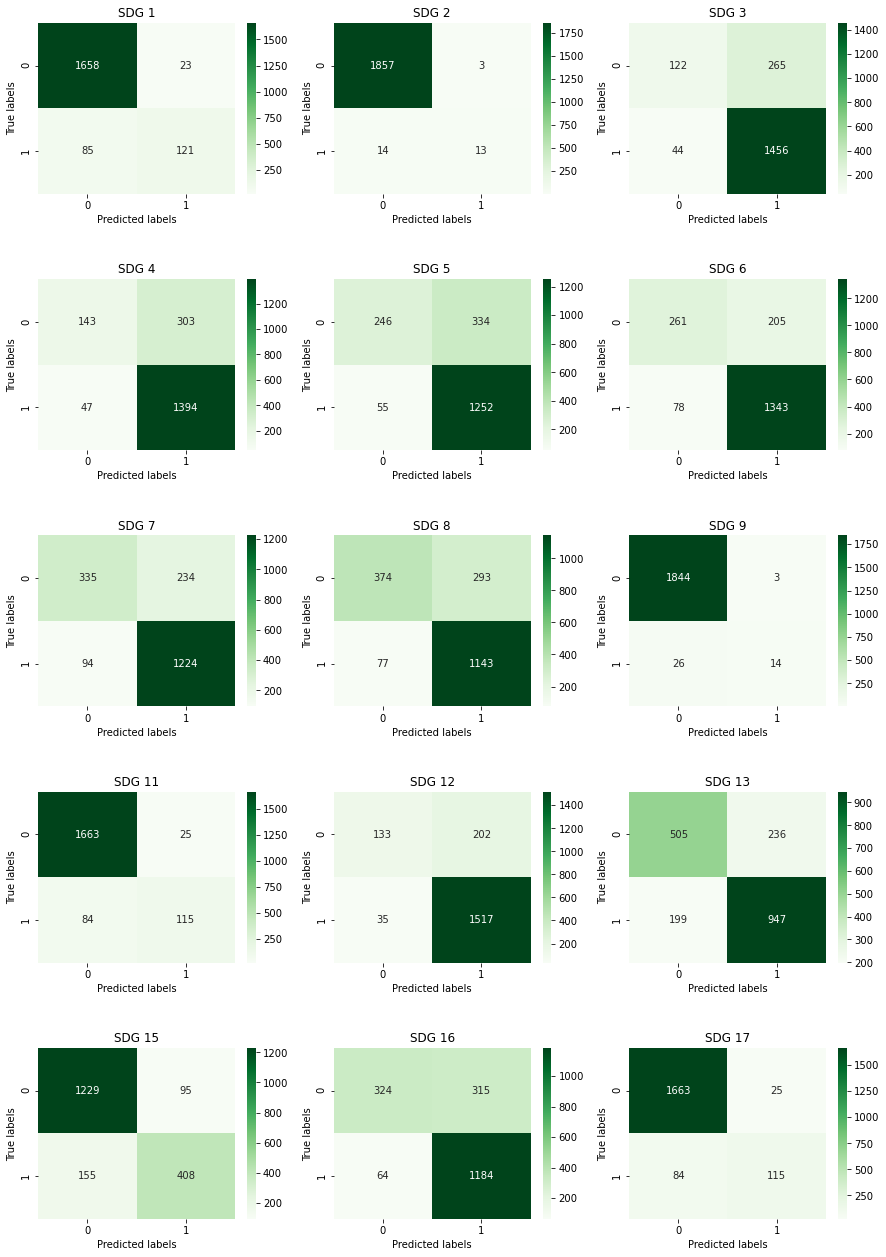

In [18]:
# Evaluation

def evaluation(model, X_test, Y_test):
    """This function creates the classification report and confusion matrices for each label.
    Args:
        model (XXX): Fitted model
        X_test (np.array): Test set examples
        Y_test (np.array): Test set labels
    Returns:
        None.
    """
    
    # Compute predictions
    predictions = model.predict(X_test)
    
    # Print classification report
    print(classification_report(Y_test, predictions))
    
    # Plot confusion matrices for each label
    sdgs = [1, 2, 3, 4, 5, 6, 7, 8, 9, 11, 12, 13, 15, 16, 17]
    counter = 0
    fig, axes = plt.subplots(nrows=5, ncols=3, figsize=(15, 22))
    plt.subplots_adjust(hspace=0.5)
    for ax in axes.flatten():
        cm = confusion_matrix(Y_test[:, counter], predictions[:, counter])
        sns.heatmap(cm, annot=True, fmt="g", ax=ax, cmap="Greens")
        ax.set_title("SDG " + str(sdgs[counter]))
        ax.set_xlabel("Predicted labels")
        ax.set_ylabel("True labels")
        counter += 1

evaluation(grid_lr, X_test, Y_test)

## 3. Classification with balanced weights

### 3.1. Logistic Regression

In [8]:
# Transform Y into single labels and learn one classifier for each
# Adjust weights inversely proportional to class frequencies in the input data
ovr = OneVsRestClassifier(LogisticRegression(class_weight="balanced"))

# Parameters to test in Grid Search
parameters = {"estimator__C": [0.1, 1, 10]} # Inverse of regularization strength, smaller values specify stronger regularization.

# Use stratified sampling in each iteration
stratified_10_fold_cv = IterativeStratification(n_splits=10, order=1)
# Optimize for weighted F1-score
scorer = make_scorer(f1_score, average="weighted")

# Grid Search
grid_lr_weighted = GridSearchCV(ovr, parameters, cv=stratified_10_fold_cv, scoring=scorer, n_jobs=-1, verbose=5)
grid_lr_weighted.fit(X_train, Y_train)

# Print results
print("Best Parameters: {}".format(grid_lr_weighted.best_params_))
print("Mean cross-validated F1-score of the best estimator: {}".format(grid_lr_weighted.best_score_))

Fitting 10 folds for each of 3 candidates, totalling 30 fits
Best Parameters: {'estimator__C': 10}
Mean cross-validated F1-score of the best estimator: 0.9080084198856074


              precision    recall  f1-score   support

           0       0.73      0.74      0.74       206
           1       0.71      0.93      0.81        27
           2       0.88      0.91      0.89      1500
           3       0.85      0.88      0.87      1441
           4       0.84      0.89      0.86      1307
           5       0.92      0.84      0.88      1421
           6       0.90      0.84      0.87      1318
           7       0.83      0.87      0.85      1220
           8       0.59      0.82      0.69        40
           9       0.71      0.72      0.72       199
          10       0.93      0.89      0.91      1552
          11       0.85      0.76      0.80      1146
          12       0.79      0.78      0.79       563
          13       0.85      0.87      0.86      1248
          14       0.71      0.72      0.72       199

   micro avg       0.86      0.85      0.86     13387
   macro avg       0.81      0.83      0.82     13387
weighted avg       0.86   

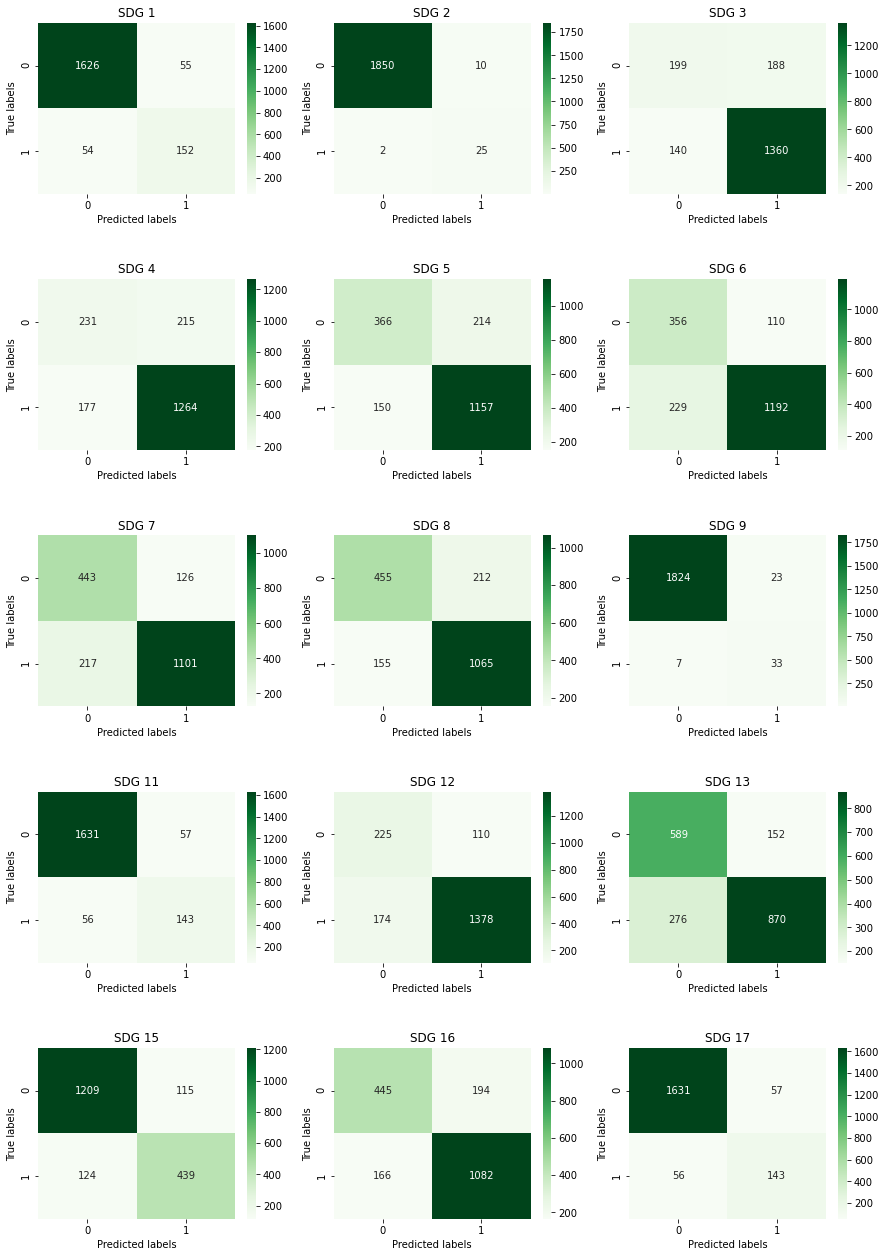

In [11]:
# Evaluation
evaluation(grid_lr_weighted, X_test, Y_test)

## 4. Classification with prior balancing of data for each label individually
- Step 1: OneVsRestClassifier will create multiple columns of y. One for each label, where that label is positive and all other are negative.
- Step 2: For each label, OneVsRestClassifier will clone the supplied pipe estimator and pass the individual data to it.
- Step 3a: Each copy of pipe will get a different version of y, which is passed to SMOTE inside it and so will do a different sampling to balance the classes there.
- Step 3b: The second part of pipe (clf) will get that balanced dataset for each label as you wanted.
- Step 4: During prediction time, the sampling part will be turned off, so the data will reach the clf as it is. The sklearn pipeline doesnt handle that part so thats why I used imblearn.pipeline.

- ToDo: combine smote with undersampling: https://machinelearningmastery.com/smote-oversampling-for-imbalanced-classification/ (or replace by SMOTEENN)

In [10]:
grid_lr_balanced

GridSearchCV(cv=IterativeStratification(n_splits=10, order=1, random_state=None,
            sample_distribution_per_fold=None),
             estimator=OneVsRestClassifier(estimator=Pipeline(steps=[('smote',
                                                                      SMOTE()),
                                                                     ('clf',
                                                                      LogisticRegression())])),
             n_jobs=-1, param_grid={'estimator__clf__C': [0.1, 1, 10]},
             scoring=make_scorer(f1_score, average=weighted), verbose=5)

### 4.1. Logistic Regression

In [11]:
# Pipeline: Resample data with smote and afterwards pass output to classifier
pipeline = Pipeline([('smote', SMOTE()), 
                     ('clf', LogisticRegression())])

# Transform Y into single labels and pass single label data to different copies of pipeline
ovr = OneVsRestClassifier(pipeline)

# Parameter to test in Grid Search
parameters = {'estimator__clf__C': [0.1, 1, 10]} # Inverse of regularization strength, smaller values specify stronger regularization.

# Use stratified sampling in each iteration
stratified_10_fold_cv = IterativeStratification(n_splits=10, order=1) 
# Optimize for weighted F1-score
scorer = make_scorer(f1_score, average = 'weighted')

# Grid Search
grid_lr_balanced = GridSearchCV(ovr, parameters, cv=stratified_10_fold_cv, scoring=scorer, n_jobs=4, verbose=5)
grid_lr_balanced.fit(X_train, Y_train)

# Print results
print("Best Parameters: {}".format(grid_lr_balanced.best_params_))
print("Mean cross-validated F1-score of the best estimator: {}".format(grid_lr_balanced.best_score_))

Fitting 10 folds for each of 3 candidates, totalling 30 fits
Best Parameters: {'estimator__clf__C': 10}
Mean cross-validated F1-score of the best estimator: 0.9064763311254576


              precision    recall  f1-score   support

           0       0.65      0.77      0.71       206
           1       0.57      0.89      0.70        27
           2       0.89      0.89      0.89      1500
           3       0.86      0.85      0.86      1441
           4       0.85      0.87      0.86      1307
           5       0.92      0.84      0.88      1421
           6       0.89      0.83      0.86      1318
           7       0.83      0.85      0.84      1220
           8       0.62      0.75      0.68        40
           9       0.64      0.77      0.70       199
          10       0.92      0.88      0.90      1552
          11       0.86      0.74      0.79      1146
          12       0.76      0.82      0.79       563
          13       0.84      0.86      0.85      1248
          14       0.64      0.77      0.70       199

   micro avg       0.85      0.84      0.85     13387
   macro avg       0.78      0.83      0.80     13387
weighted avg       0.86   

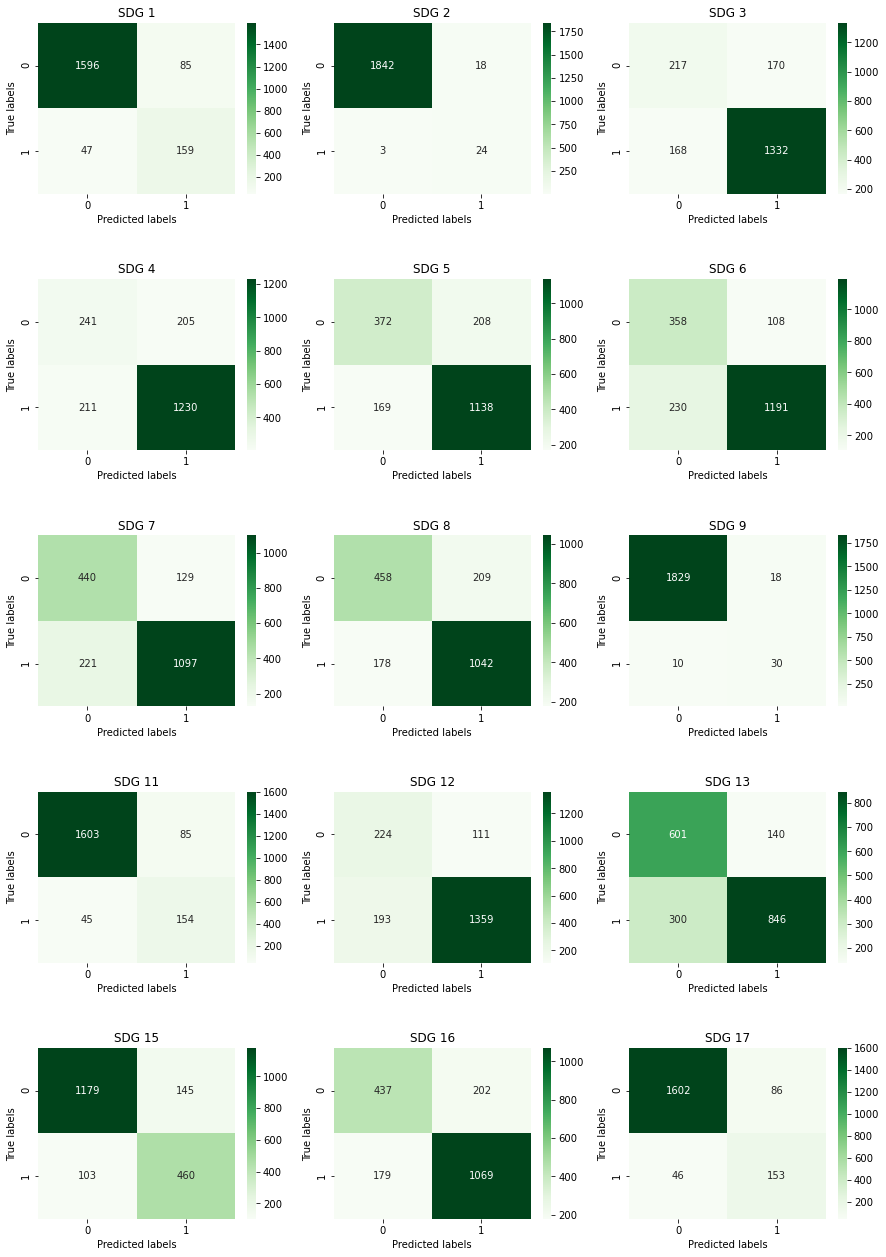

In [12]:
# Evaluation
evaluation(grid_lr_balanced, X_test, Y_test)

In [13]:
# Look at 10 most important words for each SDG (for logistic regression)
i = 0
for sdg in labels:
    coefs = grid_lr_balanced.best_estimator_.estimators_[i].named_steps['clf'].coef_[0]
    important_tokens = pd.DataFrame(data = coefs, index=tfidf.get_feature_names(), columns=['coefficient']).sort_values(by='coefficient', ascending=False)
    print(sdg)
    print(list(important_tokens.index)[0:10])
    print('\n')
    i += 1

SDG_1
['countryside', 'banking', 'stagecoach', 'mobile', 'st', 'financial', 'kb', 'unilever', 'mondel', 'wizz']


SDG_2
['johnson', 'cv', 'smucker', 'cranswick', 'tyson', 'consumer', 'food', 'greggs', 'conagra', 'unilever']


SDG_3
['safety', 'health', 'supplier', 'sustainability', 'mp', 'chain', 'cibc', 'water', 'site', 'training']


SDG_4
['employee', 'training', 'supplier', 'service', 'gri', 'million', 'work', 'engagement', 'water', 'teradata']


SDG_5
['supplier', 'global', 'human', 'right', 'goal', 'labor', 'chain', 'sustainable', 'risk', 'scope']


SDG_6
['water', 'chain', 'supplier', 'goal', 'site', 'gri', 'ghg', 'supply', 'cibc', 'product']


SDG_7
['renewable', 'sustainable', 'solar', 'energy', 'product', 'global', 'bluescope', 'cibc', 'million', 'sony']


SDG_8
['human', 'right', 'supplier', 'global', 'labor', 'chain', 'risk', 'supply', 'slavery', 'westpac']


SDG_9
['cnh', 'astrazeneca', 'colgate', 'banking', 'shinhan', 'allstate', 'prudential', 'gsk', 'pnc', 'johnson']


SD

## 4. Neural Network
(no class balancing possible)

In [37]:
from sklearn.neural_network import MLPClassifier

In [38]:
clf = MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(15,), random_state=1)

In [39]:
clf.fit(X_train, Y_train)

MLPClassifier(alpha=1e-05, hidden_layer_sizes=(15,), random_state=1,
              solver='lbfgs')

In [40]:
predictions = clf.predict(X_test)

              precision    recall  f1-score   support

           0       0.87      0.71      0.78       206
           1       0.78      0.26      0.39        27
           2       0.81      0.94      0.87      1500
           3       0.81      0.93      0.87      1441
           4       0.82      0.93      0.87      1307
           5       0.86      0.89      0.87      1421
           6       0.83      0.87      0.85      1318
           7       0.81      0.90      0.86      1220
           8       0.78      0.53      0.63        40
           9       0.84      0.69      0.76       199
          10       0.87      0.94      0.90      1552
          11       0.77      0.76      0.77      1146
          12       0.73      0.75      0.74       563
          13       0.81      0.93      0.87      1248
          14       0.84      0.68      0.76       199

   micro avg       0.82      0.88      0.85     13387
   macro avg       0.82      0.78      0.79     13387
weighted avg       0.82   

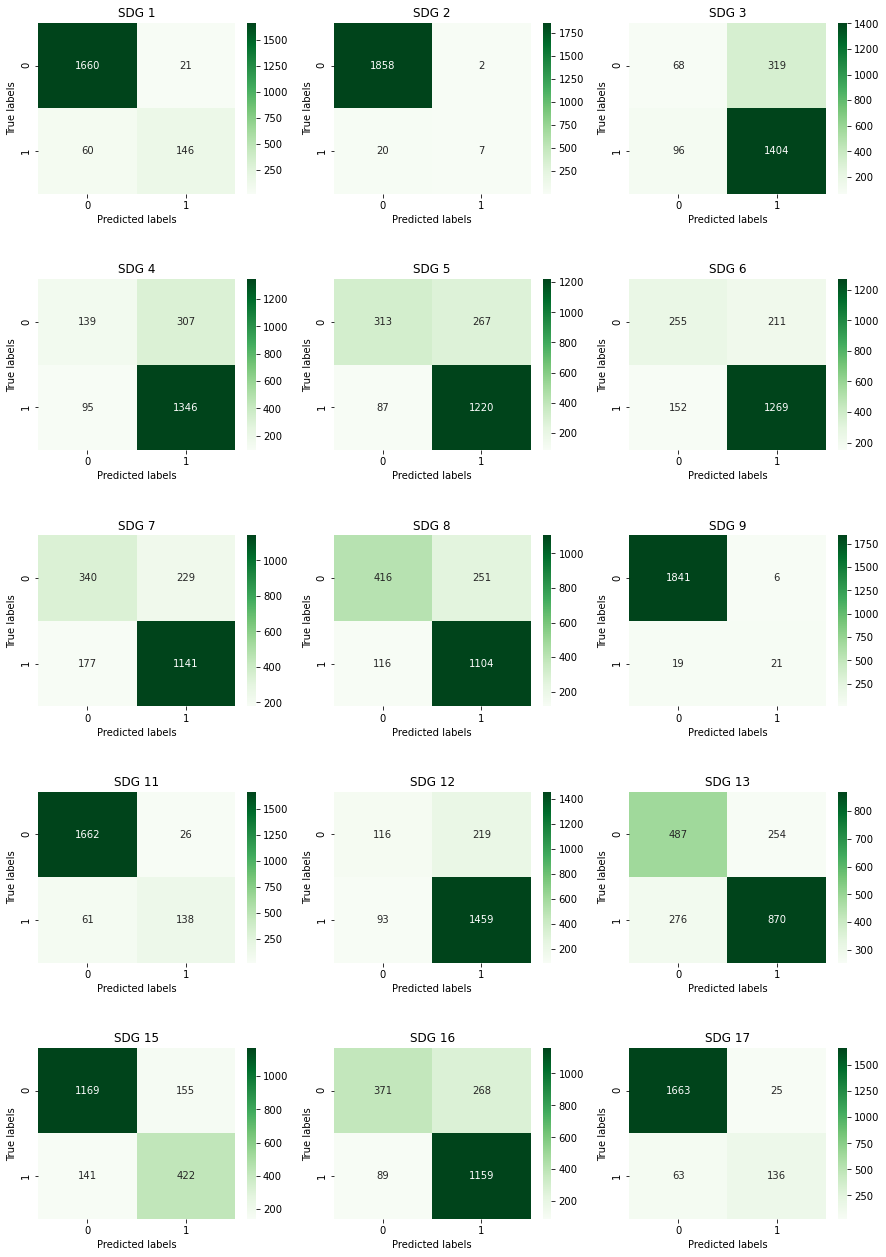

In [41]:
# Evaluation
print(classification_report(Y_test, predictions))

sdgs = [1,2,3,4,5,6,7,8,9,11,12,13,15,16,17]
counter = 0
fig, axes = plt.subplots(nrows=5, ncols=3, figsize=(15,22))
plt.subplots_adjust(hspace = 0.5)
for ax in axes.flatten():
    cm = confusion_matrix(Y_test[:,counter], predictions[:,counter])
    sns.heatmap(cm, annot=True, fmt='g', ax=ax, cmap='Greens')
    ax.set_title('SDG ' + str(sdgs[counter]))
    ax.set_xlabel('Predicted labels')
    ax.set_ylabel('True labels') 
    counter += 1

## 5. Other stuff

In [76]:
# Methode ohne GridSearchCV (stratified)

#from sklearn.naive_bayes import MultinomialNB
#from imblearn.combine import SMOTEENN

from imblearn.pipeline import Pipeline 
from sklearn.multiclass import OneVsRestClassifier
from sklearn.model_selection import cross_val_score

# This pipeline will resample the data and pass the output to MultinomialNB
pipeline = Pipeline([('smote', SMOTE(k_neighbors = 2)), # change k_neighbors
                     ('clf', LogisticRegression())])

# OVR will transform the `y` as you know and  then pass single label data to different copies of pipe  multiple times (as many labels in data)
clf = OneVsRestClassifier(pipeline)

# k-fold stratified sampling for multi-label
# http://scikit.ml/api/skmultilearn.model_selection.iterative_stratification.html
k_fold = IterativeStratification(n_splits=2, order=1) 

scores = []
for train, test in tqdm(k_fold.split(X, Y)):
    clf.fit(X[train], Y[train])
    pred = clf.predict(X[test])
    scores.append(f1_score(Y[test], pred, average='macro'))
print('Average F1 score: ' + str(np.mean(scores)))

0it [00:00, ?it/s]

Average F1 score: 0.6031969856859423


In [58]:
# Methode ohne Pipeline 

from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split

from sklearn.base import clone

sm = SMOTE(random_state=42)
clf_lr = LogisticRegression()
clf_svm = SVC()

# Data: tf-idf
tfidf = TfidfVectorizer()
X = tfidf.fit_transform(df['CSR_Text_tokenized'])

# Labels: Exclude SDGs 10 and 14
labels = ['SDG_1', 'SDG_2', 'SDG_3', 'SDG_4', 'SDG_5', 'SDG_6', 'SDG_7', 'SDG_8', 'SDG_9', 'SDG_11', 'SDG_12', 'SDG_13', 'SDG_15', 'SDG_16', 'SDG_17']
Y = df[labels].to_numpy().astype(int)

# Classifiers to test
classifiers = [clf_lr, clf_svm]

# Split into training and test data: Replace by cross validation
X_train, Y_train, X_test, Y_test = iterative_train_test_split(X, Y, test_size = 0.2)

# Store predictions
predictions = np.zeros(shape=Y_test.shape) 

for classifier in tqdm(classifiers):
    # Train one independent classifier for each label
    for i in range(Y_train.shape[1]):
        # Apply SMOTE to training data
        X_res, Y_res = sm.fit_resample(X_train, Y_train[:,i])
        # Fit classifier
        model = clone(classifier)
        model.fit(X_res, Y_res)
        # Predict
        pred = new_model.predict(X_test)
        # Store predictions
        predictions[:,i] = pred
        # Print result
    print(classifier)
    print(classification_report(Y_test, predictions))   

  0%|          | 0/2 [00:00<?, ?it/s]

LogisticRegression()
              precision    recall  f1-score   support

           0       0.82      0.45      0.58        20
           1       0.00      0.00      0.00         2
           2       0.55      0.03      0.06       177
           3       0.91      0.06      0.11       171
           4       0.64      0.04      0.08       174
           5       0.36      0.03      0.05       148
           6       0.64      0.05      0.09       140
           7       0.55      0.04      0.07       166
           8       0.18      0.40      0.25         5
           9       0.73      0.44      0.55        18
          10       0.55      0.03      0.07       172
          11       0.64      0.05      0.09       142
          12       0.27      0.05      0.08        66
          13       0.55      0.04      0.07       168
          14       0.73      0.44      0.55        18

   micro avg       0.54      0.06      0.10      1587
   macro avg       0.54      0.14      0.18      1587
weigh

In [ ]:
# Methode ohne Pipeline alt: Check um Models zu speichern

from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split

from sklearn.base import clone

sm = SMOTE(random_state=42)
clf_lr = LogisticRegression()
clf_svm = SVC()

# Data: tf-idf
tfidf = TfidfVectorizer()
X = tfidf.fit_transform(df['CSR_Text_tokenized'])

# Labels: Exclude SDGs 10 and 14
labels = ['SDG_1', 'SDG_2', 'SDG_3', 'SDG_4', 'SDG_5', 'SDG_6', 'SDG_7', 'SDG_8', 'SDG_9', 'SDG_11', 'SDG_12', 'SDG_13', 'SDG_15', 'SDG_16', 'SDG_17']
Y = df[labels].to_numpy().astype(int)

# Split into training and test data: Replace by cross validation
X_train, Y_train, X_test, Y_test = iterative_train_test_split(X, Y, test_size = 0.2)

# Classifiers to test
classifiers = [clf_lr, clf_svm]

# Store models and predictions
predictions_lr = np.zeros(shape=Y_test.shape) 
predictions_svm = np.zeros(shape=Y_test.shape) 
models_lr = [] 
models_svm = [] 

for classifier in tqdm(classifiers):
    # Train one independent classifier for each label
    for i in range(Y_train.shape[1]):
        # Apply SMOTE to training data
        X_res, Y_res = sm.fit_resample(X_train, Y_train[:,i])
        # Fit classifier
        model = clone(classifier)
        model.fit(X_res, Y_res)
        # Predict
        pred = new_model.predict(X_test)
        # Store models, parameters, and predictions
        if classifier == clf_lr:
            models_lr.append(model)
            predictions_lr[:,i] = pred
        elif classifier == clf_svm:
            models_svm.append(model)
            predictions_svm[:,i] = pred
# Print results
print('Logistic Regression')
print(classification_report(Y_test, predictions_lr))
print('SVM')
print(classification_report(Y_test, predictions_svm))  

In [39]:
# TEMP (not so useful) Look at words with highest tf-idf score for each document (does not work for full matrix)

X_tfidf = X.toarray()
vocab = tfidf.vocabulary_
reverse_vocab = {v:k for k,v in vocab.items()}
feature_names = tfidf.get_feature_names()
df_tfidf = pd.DataFrame(X_tfidf, columns = feature_names)

idx = X_tfidf.argsort(axis=1)
tfidf_max10 = idx[:,-10:]

df_tfidf['top10'] = [[reverse_vocab.get(item) for item in row] for row in tfidf_max10 ]
df_tfidf['top10']

0                 [company, million, financial, gibraltar, casino, bingo, poker, group, gaming, gambling]
1                     [business, ayana, program, jinho, product, customer, covid, gri, employee, agilent]
                                                     ...                                                 
98    [client, plc, microfinance, statementsadditional, reportstrategic, loan, group, informationgover...
99              [shipbuilding, slavery, chickasaw, jrotc, risk, esg, alabama, marinelink, vessel, austal]
Name: top10, Length: 100, dtype: object

In [80]:
#Hamming score for multilabel classification

from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import hamming_loss

def hamming_score(y_true, y_pred, normalize=True, sample_weight=None):
    '''
    Compute the Hamming score (a.k.a. label-based accuracy) for the multi-label case
    http://stackoverflow.com/q/32239577/395857
    '''
    acc_list = []
    for i in range(y_true.shape[0]):
        set_true = set( np.where(y_true[i])[0] )
        set_pred = set( np.where(y_pred[i])[0] )
        tmp_a = None
        if len(set_true) == 0 and len(set_pred) == 0:
            tmp_a = 1
        else:
            tmp_a = len(set_true.intersection(set_pred))/float(len(set_true.union(set_pred)) )
        acc_list.append(tmp_a)
    return np.mean(acc_list)

def print_score(y_pred, clf):
    print("Clf: ", clf.__class__.__name__)
    print("Hamming loss: {}".format(hamming_loss(y_pred, y_test_tfidf)))
    print("Hamming score: {}".format(hamming_score(y_pred, y_test_tfidf)))
    print("---")    

nb_clf = MultinomialNB()
sgd = SGDClassifier(loss='hinge', penalty='l2', alpha=1e-3, random_state=42, max_iter=6, tol=None)
lr = LogisticRegression()

for classifier in [nb_clf, sgd, lr]:
    clf = OneVsRestClassifier(classifier)
    clf.fit(x_train_tfidf, y_train_tfidf)
    y_pred = clf.predict(x_test_tfidf)
    print_score(y_pred, classifier)